In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Using a Neural Network to recognise hand-written digits.

## Stochastic Gradient Descent

In previous examples, we worked with a data set of 10 points. Each data point was a geometrical point in a plane, containing 2 numbers to encode point's $x$ and $y$ coordinates. Each of the data points was labeled with two possible labels, `1` and `-1`. Our goal was to predict the label of an unknown point given our 10 data points. We achieved this by defining a cost function, and using calculus (gradient descent) to minimise it. In each epoch of learning we found the derivatives of weights and biases for all 10 data points in our dataset, and then we averaged over them.<br>
For a simple task, such is binary classification of 2 dimensional points, 10 data points were sufficient. However, for more complex tasks such is recognising written digits, situation is the following:
- Each data point (an image of a handwritten digit) contains 784 numbers (brightness values of each pixel)
- Each data point is labeled with 10 possible labels (0, 1, 2, 3, 4, 5, 6, 7, 8 or 9)
- Algorithm needs to learn as many as possible multiple ways of writting a digit by hand.

For this reason, we need a large data set! We will be working with a MNIST dataset, containing 70'000 grayscale images of hand written digits, 28x28 pixels each. If we used the same strategy as before, we would need to compute gradients of 70'000 data points in one batch! That would be too ineficient. For that reason, we will be using the technique called __stochastic gradient descent__. The idea is to split the data set into smaller managable chunks called *mini batches*, and within each epoch train only a single mini batch. In this way, we will still be able to minimize our cost function by making small steps at a time. The difference is that the steps taken will be less precise than if we worked with the whole dataset at a time, but over a large number of epochs, the steps will still converge towards the function's minimum.

## Working with datasets in machine learning

In our previous example, we worked with a dataset of 10 data points. We used those points and their labels to tweak weights and biases of our neural network so that we can predict label of new unseen points.<br>
The part of the dataset that is used to train the neural network (tweak its weights and biases) is called a __training set__.
We used the visualisations to indicate how well our network is trained. To create visualisations, we defined a grid of $(x,y)$ points and passed it to our trained algorithm as inputs. The algorithm then predicted a matching label for each point, and visualised them on the screen, along with our original inputs. The grid that we used to visualise the results of our network is an example of a __testing set__ in machine learning. Testing set contains all the data that wasn't part of the original dataset, so it was never used to tweak weights and biases of the neural network. Its role is to test the prediction quality of our neural network.
The last type of dataset used in machine learning is called a __validation set__. Its role is two-fold. Its first role is to tweak meta-parameters of our neural network or test different models in order to improve prediction. The second, and more important role is that it is used to prevent __overfitting__. Overfitting means that our network has learned our training set *to well* that it became biased towards it. It will acurately predict all the training data and the similar data, but it will fail to generalise to data beyond it. <br> If we have a large amount of data, we should first split it into these categories.

In our dataset, the data is already split into the training, validation and testing set. We first load the data from the archive:

In [10]:
import gzip
import pickle

In [11]:
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Here is the amount of data points in the _training set_:

In [12]:
len(train_set[1])

50000

Here is the amount of points in the _validation set_:

In [13]:
len(valid_set[1])

10000

Here is the amount of points in the _testing set_:

In [14]:
len(valid_set[1])

10000

All of these datasets can be split into data points and their labels. Here we will split the training set:

In [15]:
train_points, train_labels = train_set

If we wish to see the any particular data point we can do it with indices:

In [16]:
train_points[0][:200] #:200 means first 200 values (out of 784)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ,

Its corresponding label is:

In [17]:
train_labels[0]

5

We can also visualise it:

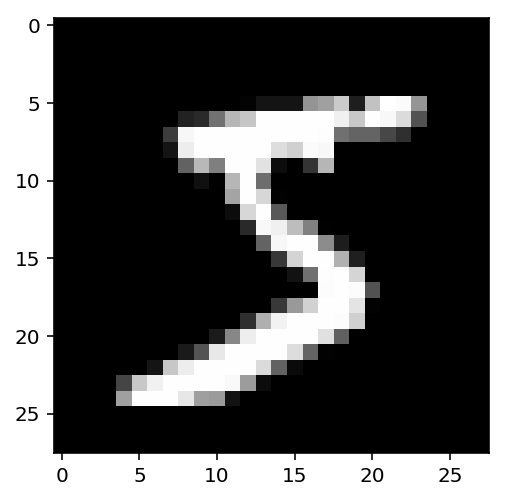

In [18]:
plt.imshow(train_points[0].reshape((28, 28)), cmap=cm.Greys_r)
plt.show()

The exact same procedure can be applied to the validation and testing sets

## Converting our dataset into column vectors

### Converting label digits to neuron representation

As we have seen the provided labels in our dataset are digits from 0-9. Our goal is to convert these to adequate activations of the output layer. Since we have 10 different digits, we will use 10 neurons in the output layer, each of them representing the probability that of a certain digit. For example, a label 5 would mean that the sixth neuron (we are counting from 0) should output 1 and all the others output 0. A label 1 would mean that the second neuron should output 1 and all the others 0, etc. <br>
This can be easily achieved. We just need to create a vector with 10 zeros, and fill the corresponding location with the value 1.

In [21]:
lab = np.zeros((10,1))
lab

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

If we want to convert the label `5` to the neuron, we simply turn array's fifth element into one:

In [22]:
lab[5]=1
lab

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

We can turn this into a function:

In [23]:
def convert_label(digit):
    neuron = np.zeros((10, 1))
    neuron[digit] = 1.0
    return neuron

In [24]:
convert_label(5)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

Now we can use this function to convert the labels of the entire training set:

In [25]:
train_labels = np.array([convert_label(digit) for digit in train_labels])

### Converting image data points to column vectors

To convert a single point, we simply need to reshape it into a column vector of the size `(784,1)`:

In [26]:
train_points[0].reshape(784,1)

array([[0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [

Now we can use this to convert the points of the entire training set:

In [27]:
train_points = [point.reshape(784,1) for point in train_points]

#### Combining data points with their labels

For simplicity, let's introduce an example of combining two lists `L1` and `L2`:

In [28]:
L1 = np.array([1,2,3,4,5,6,7,8,9])
L2 = np.array(['A','B','C','D','E','F','G','A','H'])

we can use `zip` and `list` functions to create a list of list containing an element from the first list with the element of the second list:

In [30]:
list(zip(L1,L2))

[(1, 'A'),
 (2, 'B'),
 (3, 'C'),
 (4, 'D'),
 (5, 'E'),
 (6, 'F'),
 (7, 'G'),
 (8, 'A'),
 (9, 'H')]

by using `np.array()` we can turn this into a numpy array.

In [31]:
L1zipL2 = np.array(list(zip(L1,L2)))
L1zipL2

array([['1', 'A'],
       ['2', 'B'],
       ['3', 'C'],
       ['4', 'D'],
       ['5', 'E'],
       ['6', 'F'],
       ['7', 'G'],
       ['8', 'A'],
       ['9', 'H']], dtype='<U21')

With this in mind, we ca finally put together the training points and their labels as `train_set` by using the function `zip` and converting it into a list.

In [32]:
train_set = np.array(list(zip(train_points, train_labels)))

Each element of this data set now has data points associated with the index 0 and the corresponding label associated with the index 1.

### Converting the validation and testing data sets

We can use the same procedure to convert the validation and testing sets

In [36]:
valid_points = [point.reshape(784,1) for point in valid_set[0]]
valid_labels = np.array([convert_label(digit) for digit in valid_set[1]])
valid_set = np.array(list(zip(valid_points, valid_labels)))

test_points = [point.reshape(784,1) for point in test_set[0]]
test_labels = np.array([convert_label(digit) for digit in test_set[1]])
test_set = np.array(list(zip(test_points, test_labels)))

## Creating mini-batches

The idea of mini-batches is to take the data set containing for example 50'000 points, and split it into smaller, managable chunks of data that can be trained more efficiently using our algorithm. Let's see how this can be accomplished on our toy example with `L1zipL2`:

In [37]:
L1zipL2

array([['1', 'A'],
       ['2', 'B'],
       ['3', 'C'],
       ['4', 'D'],
       ['5', 'E'],
       ['6', 'F'],
       ['7', 'G'],
       ['8', 'A'],
       ['9', 'H']], dtype='<U21')

First we define the size of chunks that we would like to subdivide our data into with `mb_size`. Then we compute the length of our data with `data_len`: 

In [38]:
mb_size = 3
data_len = len(L1zipL2)
print (f'chunk size: {mb_size}, number of data points {data_len}')

chunk size: 3, number of data points 9


The main idea is that in every epoch, we shuffle our data set by using `np.random.shuffle`:

In [39]:
np.random.shuffle(L1zipL2)
L1zipL2

array([['6', 'F'],
       ['5', 'E'],
       ['9', 'H'],
       ['1', 'A'],
       ['3', 'C'],
       ['7', 'G'],
       ['4', 'D'],
       ['8', 'A'],
       ['2', 'B']], dtype='<U21')

Then we use the function range to define the indexes of cuts:

In [40]:
list(range(0, data_len, mb_size))

[0, 3, 6]

Then we can take parts of our data and extract them according to the indexes until we reach the end of the list.

In [41]:
mini_batches = [L1zipL2[a:a+mb_size] for a in range(0, data_len, mb_size)]

for i, batch in enumerate(mini_batches):
    print (f'batch {i+1}:\n{batch}\n')

batch 1:
[['6' 'F']
 ['5' 'E']
 ['9' 'H']]

batch 2:
[['1' 'A']
 ['3' 'C']
 ['7' 'G']]

batch 3:
[['4' 'D']
 ['8' 'A']
 ['2' 'B']]



## The flexible neural network algorithm

In [42]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
    
def backprop(x, y, weights, biases, num_layers):
    # storing derivatives for the current data point
    d_biases =  [np.zeros(b.shape) for b in biases]
    d_weights = [np.zeros(w.shape) for w in weights]
    
    a = x # current activation
    activations = [x] # here we store all the activations, layer by layer
    weighted_sums = [] # here we store all the weighted sums, layer by layer
    
    # calculate all the weighted sums and activations
    for b, w in zip(biases, weights):
        w_sum = np.dot(w, a)+b #current weighted sum
        weighted_sums.append(w_sum) 
        a = sigmoid(w_sum) # current activation is updated and then the loop goes to the next layer
        activations.append(a)
    
    # computing the cost for a single example
    cost = 0.5*sum((y - a)**2)[0]
        
    #backward pass
    # output layer
    d_w_sum = (activations[-1] - y) * (activations[-1] * (1 - activations[-1]))
    d_biases[-1] = d_w_sum
    d_weights[-1] = np.dot(d_w_sum, activations[-2].T)
        
    # other layers
    for i in range(2, num_layers):
        act = activations[-i]
        d_w_sum = np.dot(weights[-i+1].T, d_w_sum) * (act * (1 - act))
        d_biases[-i] = d_w_sum
        d_weights[-i] = np.dot(d_w_sum, activations[-i-1].T)
    return (d_biases, d_weights, cost)

def prediction(a_set, weights, biases):
    data_len = len(a_set)
    number_correct = 0
    for point, label in a_set:
        a = point
        for b, w in zip(biases, weights):
            w_sum = np.dot(w, a)+b #current weighted sum
            a = sigmoid(w_sum) # current activation is updated and then the loop goes to the next layer
            a = np.round(a)
            if np.array_equal(a,label):
                number_correct += 1
    #print (f'correct: {number_correct} of {data_len}')
    return number_correct/data_len
    
def train_neural_network(sizes, train_set, step_size, mini_batch_length, no_epochs, iter_info):
    
    num_layers = len(sizes) # number of layers
    data_len = len(train_set) # number of data points
    
    # initialising random weights and biases 
    biases  = [np.random.randn(y, 1) for y in sizes[1:]]
    weights = [np.random.randn(x, y) for x, y in zip(sizes[1:], sizes[:-1])]
    
    for epoch in range(no_epochs):
        total_cost = 0 # total cost for all training examples
        np.random.shuffle(train_set) # shuffle 
        mini_batches = [train_set[a:a+mini_batch_length] for a in range(0, data_len, mini_batch_length)]
        
        for mini_batch in mini_batches:
            # in avg_d_biases/weights we store the averaged partial derivatives
            avg_d_biases =  [np.zeros(b.shape) for b in biases]
            avg_d_weights = [np.zeros(w.shape) for w in weights]
            
            for x, y in mini_batch:
                d_biases, d_weights, cost = backprop(x, y, weights, biases, num_layers)
                # averaging the derivatives of weights and biases
                avg_d_biases  = [nb+dnb for nb, dnb in zip(avg_d_biases, d_biases)]
                avg_d_weights = [nw+dnw for nw, dnw in zip(avg_d_weights, d_weights)]
                total_cost += cost

            # updating the weights and biases
            weights = [w - (step_size/len(mini_batch) * dw) 
                   for w, dw in zip(weights, avg_d_weights)]
            biases =  [b - (step_size/len(mini_batch) * db)
                  for b, db in zip(biases, avg_d_biases)]
        
        if (epoch%iter_info==0):
            print (f'epoch: {epoch+1} | total cost: {round(total_cost,2)}')
            train_prediction = round(100*prediction(train_set, weights, biases),4)
            valid_prediction = round(100*prediction(valid_set, weights, biases),4)
            print (f"Training set prediction:   {train_prediction}%\nValidation set prediction: {valid_prediction}%\n")
            if train_prediction-valid_prediction > 3.0:
                break
    return (weights, biases)

In [43]:
weights, biases = train_neural_network([784, 100, 10], 
                                       train_set, 
                                       step_size = 3.0, 
                                       mini_batch_length = 10, 
                                       no_epochs = 50, 
                                       iter_info = 5)

epoch: 1 | total cost: 9543.52
Training set prediction:   77.23%
Validation set prediction: 77.86%

epoch: 6 | total cost: 1799.96
Training set prediction:   93.158%
Validation set prediction: 91.63%

epoch: 11 | total cost: 1190.02
Training set prediction:   95.014%
Validation set prediction: 92.46%

epoch: 16 | total cost: 846.46
Training set prediction:   95.804%
Validation set prediction: 92.53%

epoch: 21 | total cost: 642.72
Training set prediction:   96.712%
Validation set prediction: 92.77%

epoch: 26 | total cost: 508.69
Training set prediction:   97.242%
Validation set prediction: 92.65%

epoch: 31 | total cost: 424.06
Training set prediction:   97.556%
Validation set prediction: 92.8%

epoch: 36 | total cost: 388.5
Training set prediction:   97.756%
Validation set prediction: 92.54%



In [44]:
print(f'Prediction quality on the testing set: {round(100*prediction(test_set, weights, biases),4)}')

Prediction quality on the testing set: 92.24
